# Classificadores sobre o conjunto de dados 'Iris'

**Visão Computacional e Percepção - TA4**

**Henrique Luiz Rieger - GRR20190357**

O notebook original e o código-fonte deste relatório encontram-se [nesse repositório](https://github.com/henrieger/ta4-visao).

## Introdução

Este trabalho visa mostrar uma aplicação básica de classificadores, como *k*NN e redes neurais, sobre um conjunto de dados bem conhecido. O *dataset* testado foi o [Iris](https://archive.ics.uci.edu/ml/datasets/iris), comumente utilizado no ensino de Inteligência Artificial para reconhecimento de padrões, contendo informações sobre as dimensões de pétalas e sépalas de flores do gênero *Iris*. Além da simples aplicação dos classificadores, foram testadas técnicas de redução de dimensionalidade. A biblioteca usada para todos os modelos foi a [Scikit Learn](https://scikit-learn.org/), enquanto a biblioteca [Pandas](https://pandas.pydata.org/) foi usada para gerenciar os dados e a [MatPlotLib](https://matplotlib.org/) para gerar os gráficos.

## Análise do *dataset*

Primeiramente, os dados são extraídos do arquivo `iris.data` com a ajuda da biblioteca Pandas. As primeiras cinco linhas do conjunto foram exibidas para checagem.

In [1]:
import pandas as pd

data = pd.read_csv("iris.data", names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'], index_col=False)
data.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Depois, foram definidos algumas estatísticas de resumo para análise dos dados. As métricas utilizadas foram:
- Valor mínimo (`min`);
- Valor máximo (`max`);
- Média (`mean`);
- Desvio padrão (`std`);
- Mediana (`median`).

In [2]:
statistics = ['min', 'max', 'mean', 'std', 'median']
aggregate = {
    'sepal_length': statistics,
    'sepal_width': statistics,
    'petal_length': statistics,
    'petal_width': statistics 
}

Primeiramente, cada estatística foi aplicada ao conjunto de dados inteiro, a partir da função `pd.DataFrame.agg`:

In [3]:
data.agg(aggregate)

,sepal_length,sepal_width,petal_length,petal_width
min,4.300000,2.000000,1.000000,0.100000
max,7.900000,4.400000,6.900000,2.500000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
median,5.800000,3.000000,4.350000,1.300000


Então, foram feitas as análises para cada classe de flor a partir da função `pd.DataFrame.groupby`:

In [4]:
data.groupby('class').agg(aggregate)

sepal_length                              sepal_width       \
                         min  max   mean       std median         min  max   
class                                                                        
Iris-setosa              4.3  5.8  5.006  0.352490    5.0         2.3  4.4   
Iris-versicolor          4.9  7.0  5.936  0.516171    5.9         2.0  3.4   
Iris-virginica           4.9  7.9  6.588  0.635880    6.5         2.2  3.8   

                                        petal_length                        \
                  mean       std median          min  max   mean       std   
class                                                                        
Iris-setosa      3.418  0.381024    3.4          1.0  1.9  1.464  0.173511   
Iris-versicolor  2.770  0.313798    2.8          3.0  5.1  4.260  0.469911   
Iris-virginica   2.974  0.322497    3.0          4.5  6.9  5.552  0.551895   

                       petal_width                               
                median         min  max   mean       std median  
class                                                            
Iris-setosa       1.50         0.1  0.6  0.244  0.107210    0.2  
Iris-versicolor   4.35         1.0  1.8  1.326  0.197753    1.3  
Iris-virginica    5.55         1.4  2.5  2.026  0.274650    2.0

A partir desses dados, é possível observar que as dimensões das pétalas (largura e comprimento) são bastante distintas entre as diferentes espécies, o que será usado posteriormente na separação das classes. 

Além das estatísticas acima definidas, também foi analisada a moda do conjunto.

In [5]:
variables = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [6]:
data[variables].mode()

,sepal_length,sepal_width,petal_length,petal_width
0,5.0,3.0,1.5,0.2


Também é possível obter as modas para cada classe:

In [7]:
for v in variables:
    print(v)
    print(data.groupby('class')[v].apply(pd.Series.mode))
    print()

sepal_length
class             
Iris-setosa      0    5.0
                 1    5.1
Iris-versicolor  0    5.5
                 1    5.6
                 2    5.7
Iris-virginica   0    6.3
Name: sepal_length, dtype: float64

sepal_width
class             
Iris-setosa      0    3.4
Iris-versicolor  0    3.0
Iris-virginica   0    3.0
Name: sepal_width, dtype: float64

petal_length
class             
Iris-setosa      0    1.5
Iris-versicolor  0    4.5
Iris-virginica   0    5.1
Name: petal_length, dtype: float64

petal_width
class             
Iris-setosa      0    0.2
Iris-versicolor  0    1.3
Iris-virginica   0    1.8
Name: petal_width, dtype: float64



Por fim, foram conferidas as frequências absolutas de cada classe, constatando que há uma igual distribuição entre todas.

In [8]:
data['class'].value_counts()

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

Podemos fazer uma visualização simples, em duas dimensões, mostrando os dados de comprimento e largura para pétalas e sépalas.

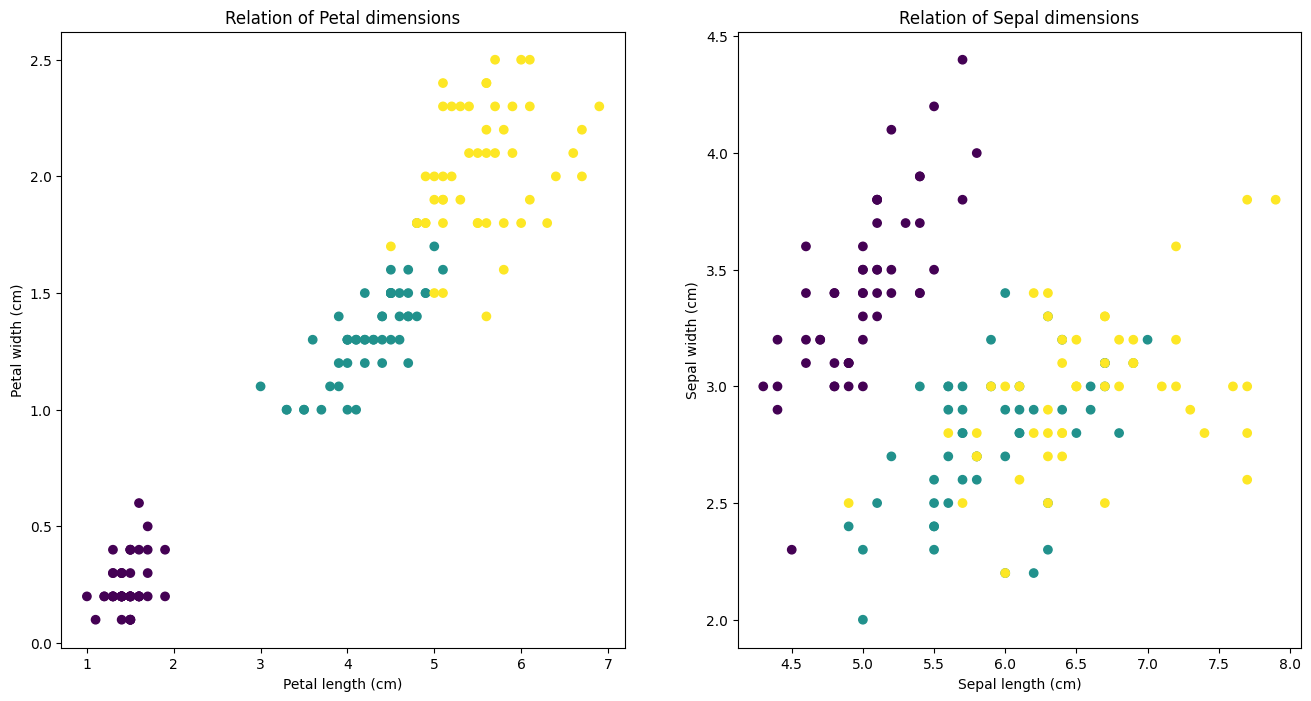

In [9]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(data['class'].drop_duplicates())
classes = [0 if d == labels[0] else 1 if d == labels[1] else 2 for d in data['class']]

fig = plt.figure(figsize=(16,8))

ax = plt.subplot(121)
plt.title('Relation of Petal dimensions')
plt.xlabel('Petal length (cm)'), plt.ylabel('Petal width (cm)')
scatter = ax.scatter(data['petal_length'], data['petal_width'], c=classes)

ax = plt.subplot(122)
plt.title('Relation of Sepal dimensions')
plt.xlabel('Sepal length (cm)'), plt.ylabel('Sepal width (cm)')
scatter = ax.scatter(data['sepal_length'], data['sepal_width'], c=classes)

Novamente, é visível como as dimensões das pétalas conseguem agrupar as classes.

## Treinando os modelos

Utilizando a biblioteca Scikit Learn, podemos criar alguns modelos de aprendizado de máquina para reconhecer as diferentes espécies do gênero Iris. Abaixo estão algumas configurações da biblioteca usadas nesses experimentos:

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

import ipywidgets as widgets
from ipywidgets import interactive, fixed, IntSlider

knn_slider = IntSlider(value=3, min=1, max=8, step=1)
iter_slider = IntSlider(value=300, min=100, max=2000, step=100)
hls_slider = IntSlider(value=100, min=50, max=200, step=25)

def new_knn(X_train, y_train, X_test, y_test, n_neighbors: int):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    print('Score =', score)

def new_mlp(X_train, y_train, X_test, y_test, random_state: int, solver: str, max_iter=iter_slider, hidden_layer_sizes=fixed(100)):
    mlp = MLPClassifier(random_state=random_state,
                         solver=solver,
                         max_iter=max_iter,
                         hidden_layer_sizes=hidden_layer_sizes
                       ).fit(X_train, y_train)
    score = mlp.score(X_test, y_test)
    print('Score =', score)

solvers = ['lbfgs', 'sgd', 'adam']

Agora, podemos fazer a divisão dos dados a partir do DataFrame obtido na seção anterior. O conjunto foi separado de forma aleatória, reservando 80% das entradas para treinamento e 20% para testes.

In [11]:
(X, y) = (data[variables], data['class'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Primeiramente, testamos um classificador *k*NN (*k-nearest neighbors*). Para qualquer valor de *k*, podemos ver que a classificação dos dados de teste é perfeita.

In [12]:
interactive(
    new_knn,
    X_train=fixed(X_train), y_train=fixed(y_train),
    X_test=fixed(X_test), y_test=fixed(y_test),
    n_neighbors=knn_slider
)

interactive(children=(IntSlider(value=3, description='n_neighbors', max=8, min=1), Output()), _dom_classes=('w…

Vamos então testar um clássico *Multi-layer Perceptron*, ou MLP. Os principais parâmetros podem ser alterados para testes no exemplo abaixo. Observe que apenas o resolvedor `sgd` não consegue obter um *score* perfeito.

In [13]:
interactive(
    new_mlp,
    X_train=fixed(X_train), y_train=fixed(y_train),
    X_test=fixed(X_test), y_test=fixed(y_test),
    random_state=fixed(1), solver=solvers
)

interactive(children=(Dropdown(description='solver', options=('lbfgs', 'sgd', 'adam'), value='lbfgs'), IntSlid…

## Reduzindo as dimensões do problema

Agora, podemos tentar aplicar uma redução de dimensionalidade, de forma a tentar condensar os dados de todas as medidas em apenas duas dimensões. Isso deve ser possível já que as medidas das pétalas parecem fornecer informação suficiente.

Primeiramente, no entanto, será utilizada uma técnica "automatizada" conhecida como *Principal Component Analysis*, ou PCA. Esta técnica tenta preservar as distâncias entre os pontos do conjunto de dados ao mesmo tempo que reduz suas dimensões. [Este link](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) contém uma explicação mais completa sobre o funcionamento do método.

Abaixo, podemos ver como os pontos ficam distribuídos ao aplicar o PCA sobre os dados para duas dimensões.

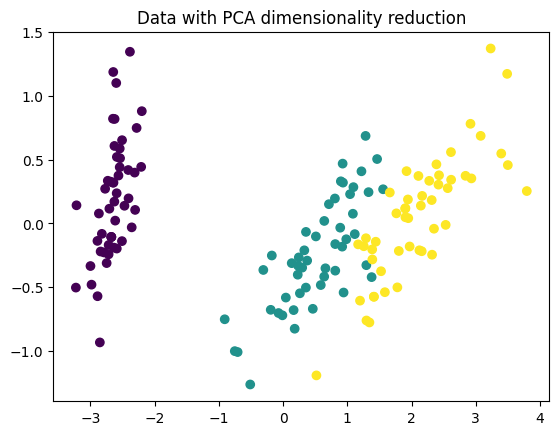

In [14]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)

rx = [r[0] for r in reduced_data]
rz = [r[1] for r in reduced_data]

fig, ax = plt.subplots()
plt.title('Data with PCA dimensionality reduction')
scatter = ax.scatter(rx, rz, c=classes, label=labels)

Ainda é possível observar uma boa separação entre as classes.

Novamente, vamos treinar o *k*NN para o novo conjunto com dimensões reduzidas.

In [15]:
rX_train, rX_test, ry_train, ry_test = train_test_split(reduced_data, y, test_size=0.2, random_state=1)

In [16]:
interactive(
    new_knn,
    X_train=fixed(rX_train), y_train=fixed(ry_train),
    X_test=fixed(rX_test), y_test=fixed(ry_test),
    n_neighbors=knn_slider
)

interactive(children=(IntSlider(value=3, description='n_neighbors', max=8, min=1), Output()), _dom_classes=('w…

Com o *k*NN, a redução nas dimensões continua fornecendo um *score* perfeito.

Vamos testar também para o MLP.

In [17]:
interactive(
    new_mlp,
    X_train=fixed(rX_train), y_train=fixed(ry_train),
    X_test=fixed(rX_test), y_test=fixed(ry_test),
    random_state=fixed(1), solver=solvers
)

interactive(children=(Dropdown(description='solver', options=('lbfgs', 'sgd', 'adam'), value='lbfgs'), IntSlid…

Observe que, para todos os resolvedores, o MLP não consegue mais obter um resultado perfeito, mesmo após a convergência. Isso ocorre pois, ao reduzir a dimensionalidade, parte da informação é perdida. Observe o que ocorre se tentarmos apenas com os dados das pétalas de flores:

In [18]:
interactive(
    new_mlp,
    X_train=fixed(X_train[['petal_length', 'petal_width']]),
    y_train=fixed(y_train),
    X_test=fixed(X_test[['petal_length', 'petal_width']]),
    y_test=fixed(y_test),
    random_state=fixed(1), solver=solvers
)

interactive(children=(Dropdown(description='solver', options=('lbfgs', 'sgd', 'adam'), value='lbfgs'), IntSlid…

A diferença nos resultados é negligenciável, mesmo observando que as dimensões das pétalas deveriam ser suficientes para separar as classes. Vale observar, no entanto, que os valores finais de *score* ainda são relativamente altos. 

Outras topologias de MLPs provavelmente são capazes de separar as classes. Vamos aumentar o tamanho das camadas ocultas e testar novamente.

In [19]:
interactive(
    new_mlp,
    X_train=fixed(X_train[['petal_length', 'petal_width']]),
    y_train=fixed(y_train),
    X_test=fixed(X_test[['petal_length', 'petal_width']]),
    y_test=fixed(y_test),
    random_state=fixed(1), solver=solvers,
    hidden_layer_sizes=hls_slider
)

interactive(children=(Dropdown(description='solver', options=('lbfgs', 'sgd', 'adam'), value='lbfgs'), IntSlid…

Mesmo dobrando o tamanho da camada oculta, não foi possível aumentar o *score* do modelo. Infelizmente, o Scikit Learn não permite outras alterações na topologia do MLP, logo não há como "compensar" a perda de informação sofisticando a rede. Para isso, outras bibliotecas, como TensorFlow ou Keras, podem ser utilizadas em outros estudos.

## Conclusões

Os dados presentes no Iris são facilmente separáveis tanto pelo modelo *k*NN, para qualquer tamanho de *k*, quanto pelo MLP com *solver* LBFGS. Para os dados com dimensões reduzidas, o *k*NN ainda consegue fazer a separação, enquanto o MLP passa a ter um pequeno erro, independente do *solver* ou do tamanho da camada oculta. Ainda assim, todos os modelos testados conseguem obter bons resultados ao classificar os conjuntos do *dataset* fornecido.